I have been looking for a nice excuse to play with ```rvest``` and since we're starting to work with "CAZYme" gene annotations in the Buckley lab, scraping the [CAZy](http://www.cazy.org/) website seemed like a good fit. I'm starting simple and will build as I go. This post is just an example of producing a table of [EC](https://en.wikipedia.org/wiki/EC_number) numbers and "clan" groupings of the CAZy glycoside hydrolase families.

We'll pull in all the libraries we need first.

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R
library(rvest)
library(plyr); library(dplyr)
library(magrittr)
library(tidyr)
library(ggplot2)

The first thing I will do is read in the CAZy website [glycoside hydrolase](http://www.cazy.org/Glycoside-Hydrolases.html) page.

In [6]:
%%R
cazy = html_session("http://www.cazy.org/Glycoside-Hydrolases.html")

After inspecting the page, it's clear that the clan names are in table cells of the "thclan" ```css``` class and the corresponding families are in cells with the "clan" ```css``` class. We can use the ```css``` to quickly get the membership of each clan. 

Try the [SelectorGadget](http://selectorgadget.com/) for inspecting webpage elements. It's a great way to find ```css``` selectors for scraping.

You can find a nice explanation of these ```rvest``` functions [here](https://github.com/hadley/rvest).

In [7]:
%%R
clans = cazy %>% html_nodes(".thclan") %>% html_text()
families.clan = cazy %>% html_nodes(".clan") %>% html_text()

The following is just a quick function to parse the text that we just scraped into a dataframe. This took some trial and error but parsing the family string required the following steps: 

1. trim leading and trailing whitespace (```trimws```), 
1. split on whitespace (```strsplit```), 
1. and ```unlist```.

This function takes an index and spits out a dataframe with two columns: one for the clan and one for the families.

In [8]:
%%R
get_clan_df = function(i) {
    data.frame(clan = clans[i], 
               family = families.clan[i] %>% 
                   trimws %>% # remove leading and trailing whitespace
                   strsplit("\\s+", perl = TRUE) %>% # split families into 
                                                     # individual elements
                   unlist, # make it a vector
               stringsAsFactors = FALSE)
}

We can loop through all the clans using ```ldply``` to build a single dataframe of all the clans.

In [9]:
%%R
N = length(clans)
clan_df = ldply(1:N, get_clan_df)
clan_df %>% head

  clan family
1 GH-A      1
2 GH-A      2
3 GH-A      5
4 GH-A     10
5 GH-A     17
6 GH-A     26


The EC information can be parsed similarly. Here the ```css``` selectors are "thec" for the EC numbers and "ec" for the families. For some reason two unrelated table cells earlier in the page have the "ec" class too so I had to omit those from the final families vector.

In [10]:
%%R
ecs = cazy %>% html_nodes(".thec") %>% html_text()
families.ec = cazy %>% html_nodes(".ec") %>% html_text()
families.ec = families.ec[3:length(families.ec)]

In [11]:
%%R
get_ec_df = function(i) {
    data.frame(ec = ecs[i], 
               family = families.ec[i] %>%
                   trimws %>%
                   strsplit("\\s+", perl = TRUE) %>%
                   unlist,
               stringsAsFactors = FALSE)
}

In [12]:
%%R
N = length(ecs)
ec_df = ldply(1:N, get_ec_df)

This information will be more useful when we're tallying the annotations in a real dataset, but, we can also do a quick analysis. It looks like the "GH-A" clan has the most glycoside hydrolase families and the most EC activities. Beyond that, the clans have similar numbers of families but vary with respect to number of EC activities. (Note how the "clan" column can be sorted using ```magrittr``` and ```dplyr```. Graphs that aren't sensibly sorted are a huge pet peeve of mine :) . Also, I'm using ```tidyr``` to get the table in the proper orientation for plotting.)

Source: local data frame [6 x 3]

  clan          key count
1 GH-A     ec.count    58
2 GH-H     ec.count    32
3 GH-A family.count    19
4 GH-B     ec.count    17
5 GH-D     ec.count    15
6 GH-J     ec.count    15


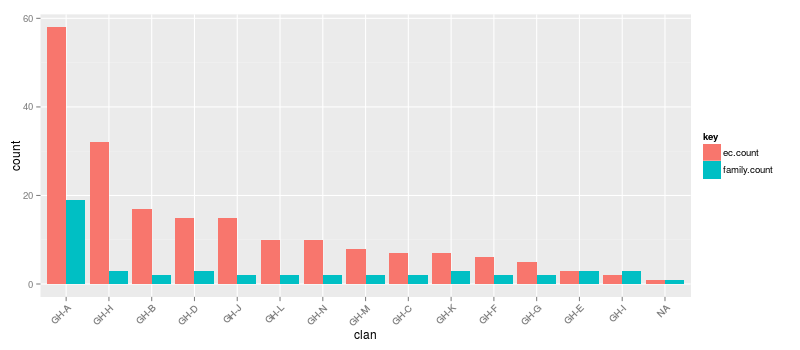

In [17]:
%%R -w 800 -h 350
d = ec_df %>% 
    left_join(clan_df) %>%
    group_by(clan) %>%
    summarize(ec.count = length(unique(ec)), 
              family.count = length(unique(family))) %>%
    gather(key, count, -clan) %>% {
        ec.sort = arrange(., desc(count)) %>% # sort by count 
            filter(key == "ec.count") %>%
            extract2("clan") # get a list of clans sorted by ec count
        mutate(., clan = factor(clan, levels = ec.sort)) # make the clan 
                                                         # a factor sorted 
                                                         # by ec count
    }

d %>% arrange(desc(count)) %>% head %>% print

p = ggplot(d, aes(x = clan, y = count, fill = key)) +
    geom_bar(stat = "identity", position = "dodge") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

p

We can also look at the families with the most associated EC activities. Family 13 is has 30 EC activities associated with it! I found this somewhat baffling but it looks like Family 13 and other CAZy glycoside hydrolase families have been broken down into subfamilies that have more specific activites:

><b>Dividing the large glycoside hydrolase family 13 into subfamilies: 
>towards improved functional annotations of alpha-amylase-related proteins.</b>
>Stam MR, Danchin EG, Rancurel C, Coutinho PM, Henrissat B.
>Protein Eng Des Sel. 2006 Dec;19(12):555-62.

Source: local data frame [6 x 2]

  family count
1     13    30
2      1    25
3      5    23
4     16    14
5      3    14
6     32    14


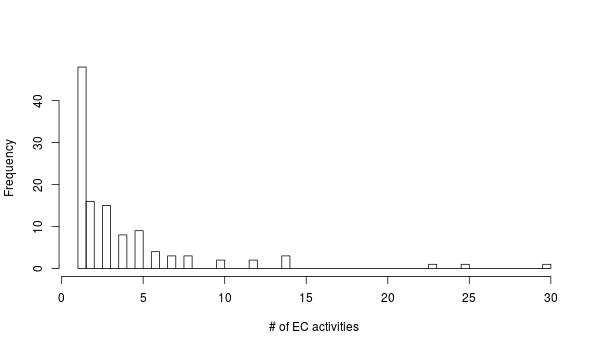

In [14]:
%%R -h 350 -w 600
ec_df %>%
    group_by(family) %>%
    summarize(count = n()) %>%
    arrange(desc(count)) %>% {print(head(.)); .} %>%
    extract2("count") %>%
    hist(breaks = 100, main = "", xlab = "# of EC activities")

This was so painless! It's so easy to use css selectors to get the information we're after.